# Portfolio Optimization



In [ ]:
## download libraries
!pip install qiskit[all]
!pip install qiskit_aer
!pip install qiskit_optimization
!pip install qiskit_finance
!pip install scipy

In [ ]:
!pip install dwave-ocean-sdk

## Introduction




> ## here we are framing the mathematical representation of our objective function.



This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function.
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Sampling Variational Quantum Eigensolver (`SamplingVQE`) or the Quantum Approximate Optimization Algorithm (`QAOA`) from [Qiskit Algorithms](https://qiskit.org/ecosystem/algorithms/apidocs/qiskit_algorithms.html#minimum-eigensolvers) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
[Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.](https://arxiv.org/abs/1907.04769)

In [ ]:
## import seciton

from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf

## Define problem instance

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We use a random portfolio problem for this notebook. It is straight-forward to extend this to using real financial data as illustrated here


In [ ]:
## passing start and end date
start_date = "2012-01-01"
end_date = "2022-01-01"

assets = ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE"] ##list of assets

## code to give a call to yfinance api request.
stocks_data = yf.download(assets, start = start_date, end = end_date)['Adj Close']
stocks_data ## df of Adj. closing price

[*********************100%%**********************]  8 of 8 completed


In [ ]:
stock_return = stocks_data.pct_change() ## applying percentage change on the adj closing price

In [ ]:
mu = stock_return.mean() ## mean of the df
sigma = stock_return.cov() ## covariance of the df
sigma = np.array(sigma)
mu = np.array(mu)
num_assets = len(mu)

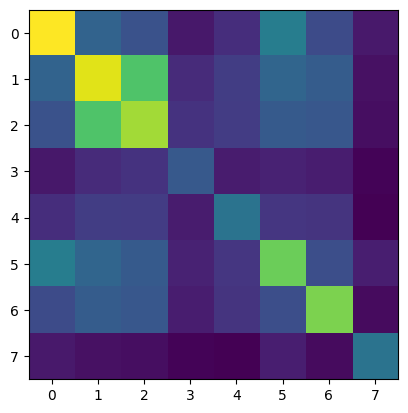

In [ ]:
# plot heatmap of covariance matrix
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [ ]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

## passing the input to portfolio optimization class, getting a quadratic program as an output.
portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0001595198694878035*x_0^2 + 0.000132823609926143..., 8 variables, 1 constraints, 'Portfolio optimization'>

We define some utility methods to print the results in a nice format.

## NumPyMinimumEigensolver (as a classical reference)
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The result is returned as a dictionary.

In [ ]:
## numpy minimum eigen solver is a classical method which mimics the working of vqe/qaoa algorithm.

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

exact_result = exact_eigensolver.solve(qp)

exact_result

<MinimumEigenOptimizationResult: fval=-0.002925098242321093, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, status=SUCCESS>

## Solution using `SamplingVQE`
We can now use the Sampling Variational Quantum Eigensolver (`SamplingVQE`) to solve the problem. We will specify the optimizer and variational form to be used.

In [ ]:
## running VQE algorithm

from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
vqe_result = svqe.solve(qp)
print(vqe_result.x) ## this is a binary output, 1 means that stock is selected, and 0 is otherwise.
vqe_result

[1. 0. 0. 0. 1. 1. 1. 0.]


<MinimumEigenOptimizationResult: fval=-0.002823934954760241, x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=1.0, x_7=0.0, status=SUCCESS>

### Solution using `QAOA`

We also show here a result using the Quantum Approximate Optimization Algorithm (`QAOA`). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [ ]:
## running QAOA Algo

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qp)
print(qaoa_result.x) ## this is a binary output, 1 means that stock is selected, and 0 is otherwise.
qaoa_result


[1. 0. 1. 0. 0. 1. 1. 0.]


<MinimumEigenOptimizationResult: fval=-0.002925098242321093, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, status=SUCCESS>

## Dwave code

In [ ]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from dwave.system import DWaveSampler, EmbeddingComposite
import dimod

In [ ]:
qp2qubo = QuadraticProgramToQubo()  ## converting qp to qubo, qubo is a matrix which has to be passed to the dwave function as an input
qubo = qp2qubo.convert(qp) ## returns qubo matrix

assets_used = assets

sampler_dw = DWaveSampler(solver='Advantage_system4.1', token = 'DEV-3092b857364ac14474b6cca827ed602eda60252d')  ## calling Adv. System 4.1 dwave machine as a solver
sampler_qa = EmbeddingComposite(sampler_dw)

bqm_qubo = dimod.as_bqm(qubo.objective.linear.to_array(), qubo.objective.quadratic.to_array(), dimod.BINARY) ## convrts qubo compatible for binary quadratic model

embedded_sampler = EmbeddingComposite(sampler_dw)
result_using_dwave = embedded_sampler.sample(bqm_qubo, label="example_qp", num_reads=5000)
# print(result_using_dwave)

opt_output_dwave = result_using_dwave.first.sample.values() ## gives the best output, which has minimum energy. its idea is overall same as VQE in terms of energy optimization.
opt_output_dwave = list(opt_output_dwave)
print(opt_output_dwave)
output_dict = dict(zip(assets_used, opt_output_dwave))
print(output_dict)

[1, 0, 1, 0, 0, 1, 1, 0]
{'JPM': 1, 'GS': 0, 'MSFT': 1, 'AAPL': 0, 'KO': 0, 'WMT': 1, 'MCD': 1, 'NKE': 0}


## Weights allocation

In [ ]:
## weights allocation process is done on the classical computer.
## passing the assets which has been selected by the quantum computer at assets selection part.

selected_assets = opt_output_dwave   # [0, 0, 1, 1, 0, 0, 1, 1]
assets = ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE"]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['JPM', 'MSFT', 'WMT', 'MCD']


In [ ]:
selected_stocks_data = stocks_data[my_assets]

In [ ]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))  ## log returns of the selected stocks
log_return.head()

,JPM,MSFT,WMT,MCD
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.006315,0.023261,-0.010330,0.005549
2012-01-05,0.020672,0.010167,-0.004869,0.004417
2012-01-06,-0.009009,0.015415,-0.007093,0.007684
2012-01-09,-0.001698,-0.013250,0.003046,-0.009588


In [ ]:
# to start with some random input, we have initialized an array of weights which sums to 1.

import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.35987168 0.01452553 0.43044343 0.19515936]


In [ ]:
## formulating the objective function for weights allocation

from scipy.optimize import minimize

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol
    return np.array(sr)

# minimize negative Sharpe Ratio
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights):
    return np.sum(weights) - 1

In [ ]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum}) ## constraints which adds satisfiability of sum should be 1 exactly. this is an equality constraint.

In [ ]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets))) ## bound consition, which doesn't allows weights to be less than 0 or greater than 1.

In [ ]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.3, 0.4, 0.2, 0.1]
# tuple((0, 1) for stocks in range(len(my_assets)))

In [ ]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)  ## scipy method for optiomization. SLSQP solver is used to solve quadratic programming problem.
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1158304956018665
       x: [ 1.062e-01  6.169e-01  1.647e-01  1.122e-01]
     nit: 4
     jac: [ 9.324e-05 -1.156e-05  1.692e-04 -2.730e-04]
    nfev: 20
    njev: 4

In [ ]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [ ]:
tot_weights = np.sum(my_weights) ## checking if the weights we got satisfy the sum should be equal to 1 condition.
tot_weights

1.0

In [ ]:
weights_alloc = dict(zip(my_assets, my_weights)) ## weights dictionary for each asset.
weights_alloc

{'JPM': 0.10618902512566182,
 'MSFT': 0.6169241753025179,
 'WMT': 0.16473049236847498,
 'MCD': 0.11215630720334543}

In [ ]:
# formula to calculate sharpe ratio, returns and risk of a portfolio based on on

ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
 sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100,
    'sharpe_ratio' : sharpe_ratio
}

sharpe ratio of your porrtfolio after optimization is  1.3968138358235755


In [ ]:
risk_ret_dict_of_quantum

{'returns': 22.10705634098746,
 'risk': 15.826773600043067,
 'sharpe_ratio': 1.3968138358235755}